# Dealiasing the data
- **Note** : The data should be periodic in x and y domain

In [1]:
import numpy as np
import jax.numpy as jnp

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.io import loadmat
import h5py

from py2d.initialize import initialize_wavenumbers_2DFHIT, gridgen
from py2d.dealias import multiply_dealias, multiply_dealias_physical_jit
from py2d.convert import Omega2Psi_2DFHIT
from py2d.filter import filter2D_2DFHIT
from py2d.spectra import spectrum_angled_average_2DFHIT


# Define the domain size and number of grid points
Lx, Ly = 2*np.pi, 2*np.pi # Domain size
Nx, Ny = 1024, 1024 # Number of grid points

# Generate grid with given domain size and number of grid points
Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')

# Initialize wavenumbers for 2D Fourier-based pseudo-spectral differentiation
Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_2DFHIT(Nx, Ny, Lx, Ly, INDEXING='ij')

### Comparison of aliased term with dealiased using numpy and jax

In [2]:
# Compute the analytical function on the grid

# Define parameters 
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'

# Load the data from the file
data = loadmat(filename)
# Extract the Omega data from the file
Omega_DNS = data['Omega']
Psi_DNS = Omega2Psi_2DFHIT(Omega_DNS, invKsq=invKsq)

fa_DNS = Omega_DNS
fb_DNS = Psi_DNS
fab_DNS = fa_DNS*fb_DNS

fab = filter2D_2DFHIT(fab_DNS, filterType=None, coarseGrainType='spectral', Ngrid=[Nx,Ny])

fa = filter2D_2DFHIT(fa_DNS, filterType=None, coarseGrainType='spectral', Ngrid=[Nx,Ny])
fb = filter2D_2DFHIT(fb_DNS, filterType=None, coarseGrainType='spectral', Ngrid=[Nx,Ny])

fab_dealiased = multiply_dealias(fa, fb, dealias=True)
fab_dealiased_jit = multiply_dealias_physical_jit(fa, fb)

fab_aliased = multiply_dealias(fa, fb, dealias=False)

# Calculate MSE and correlation for dealiased version
mse_dealiased = mean_squared_error(fab.flatten(), fab_dealiased.flatten())
corr_dealiased, _ = pearsonr(fab.flatten(), fab_dealiased.flatten())

# Calculate MSE and correlation for aliased version
mse_aliased = mean_squared_error(fab.flatten(), fab_aliased.flatten())
corr_aliased, _ = pearsonr(fab.flatten(), fab_aliased.flatten())

# Calculate MSE and correlation for dealiased version using JIT
mse_dealiased_jit = mean_squared_error(fab.flatten(), fab_dealiased_jit.flatten())
corr_dealiased_jit, _ = pearsonr(fab.flatten(), fab_dealiased_jit.flatten())

# Print MSE and correlation coefficients
print(f"MSE (Aliased): {mse_aliased}, Correlation coefficient (Aliased): {corr_aliased}")
print(f"MSE (Dealiased): {mse_dealiased}, Correlation coefficient (Dealiased): {corr_dealiased}")
print(f"MSE (Dealiased JIT): {mse_dealiased_jit}, Correlation coefficient (Dealiased JIT): {corr_dealiased_jit}")



MSE (Aliased): 1.7334967069749647e-06, Correlation coefficient (Aliased): 0.9999999632548083
MSE (Dealiased): 1.1015911844146861e-06, Correlation coefficient (Dealiased): 0.9999999766494185
MSE (Dealiased JIT): 1.1015836731547334e-06, Correlation coefficient (Dealiased JIT): 0.9999999766495751


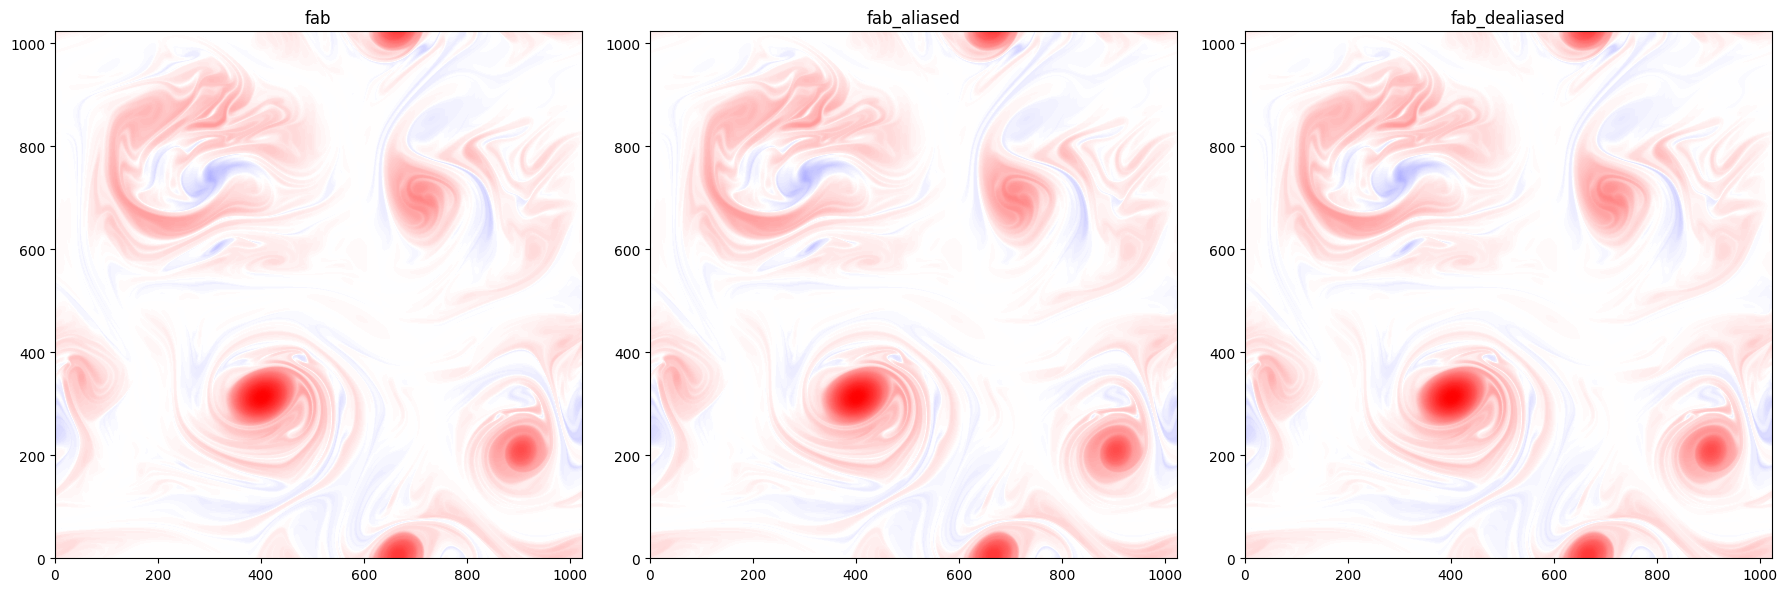

In [3]:
# Setting up the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Common colormap and normalization
cmap = 'bwr'

vmax = np.max(fab)
vmin = -vmax

# Normalization
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Plotting fab
contour1 = ax[0].contourf(fab, cmap=cmap, levels=100, vmax=vmax, vmin=vmin)
ax[0].set_title('fab')
ax[0].set_aspect('equal')

# Plotting fab_dealiased
contour2 = ax[1].contourf(fab_aliased, cmap=cmap, levels=100, vmax=vmax, vmin=vmin)
ax[1].set_title('fab_aliased')
ax[1].set_aspect('equal')

# Plotting fab_aliased
contour3 = ax[2].contourf(fab_dealiased, cmap=cmap, levels=100, vmax=vmax, vmin=vmin)
ax[2].set_title('fab_dealiased')
ax[2].set_aspect('equal')


plt.tight_layout()
plt.show()


### Testing the dealiasing Code by comparing the norm of the SGS before and after dealising
- Dealising should remove errors at high wavenumbers hence reducing the norm (The difference would only be visible for sharp-spectral filter)

Testing for dealiasing
The dealiased Leonard stress (coarse grained) for spectral_square filter is zero, 


/Users/karanjakhar/Documents/EquationDiscovery/development/py2d_test/py2d/spectra.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  A_angled_average_spectra[0] = A_hat[0,0]
/Users/karanjakhar/Documents/EquationDiscovery/development/py2d_test/py2d/spectra.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  A_angled_average_spectra[k] = np.sum(A_hat[tempInd])


Re20kNX1024nx4ny0r0p1   32
Mean maximum absolute value of all Leonard stress components - Dealiased : 4.440892098500626e-15
Mean maximum absolute value of all Leonard stress components - aliased   : 0.3106192832873407
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.1927647193251145
Mean maximum absolute value of all Cross stress components - aliased     : 0.19276471932511458
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.034113173740936184
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.03411317374541411


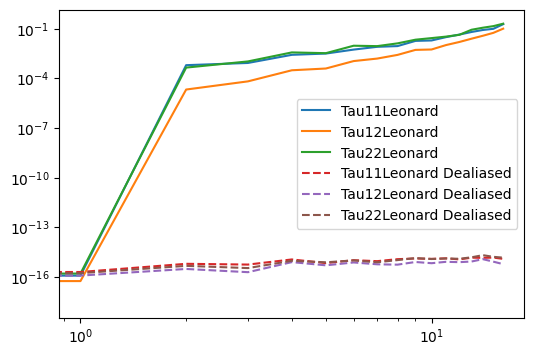

Re20kNX1024nx4ny0r0p1   64
Mean maximum absolute value of all Leonard stress components - Dealiased : 5.773159728050814e-15
Mean maximum absolute value of all Leonard stress components - aliased   : 0.1973866036010301
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.13325556290978097
Mean maximum absolute value of all Cross stress components - aliased     : 0.13325556290978102
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.02109225459738699
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.021092254557378558


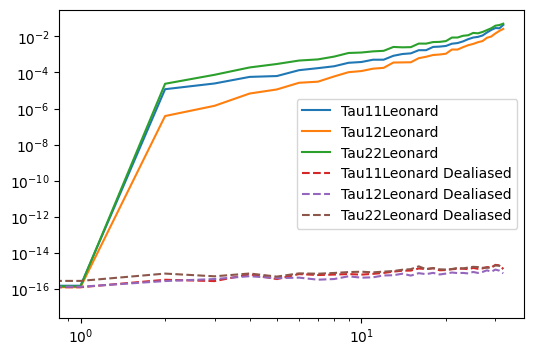

Re20kNX1024nx4ny0r0p1   128
Mean maximum absolute value of all Leonard stress components - Dealiased : 7.401486830834377e-15
Mean maximum absolute value of all Leonard stress components - aliased   : 0.13913791466105596
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.09581885674703898
Mean maximum absolute value of all Cross stress components - aliased     : 0.09581885674703895
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.014509535952863334
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.014509536084952679


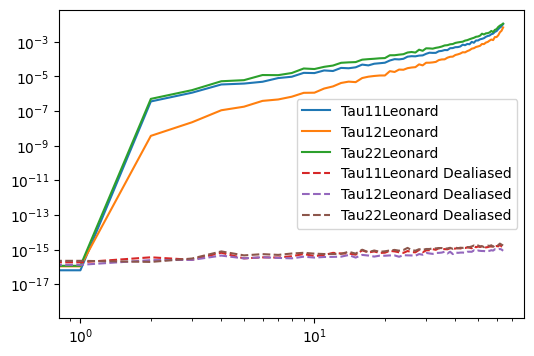

Re20kNX1024nx4ny0r0p1   256
Mean maximum absolute value of all Leonard stress components - Dealiased : 8.215650382226158e-15
Mean maximum absolute value of all Leonard stress components - aliased   : 0.10565781947814723
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.07316240398850914
Mean maximum absolute value of all Cross stress components - aliased     : 0.0731624039885091
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.010948929072731341
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.010948929832485401


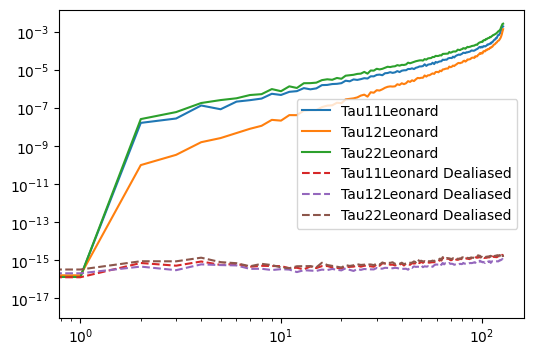

In [4]:
from py2d.SGSterms import TauLeonard, TauCross, TauReynolds, Tau

# Following code tests the accurancy of the SGS decomposition code by ensuring that the sum of Leonard, Cross, and Reynolds is equal to SGS term
print("Testing for dealiasing")
print("The dealiased Leonard stress (coarse grained) for spectral_square filter is zero, ")

dataType = 'Re20kNX1024nx4ny0r0p1' #  Re20kNX1024nx4ny0r0p1 Re20kNX1024nx4ny0r0p01 Re20kNX1024nx25ny25r0p1 Re100kNX2048nx4ny0r0p1

# Initialize filter and coarse grain types for SGS terms calculation
filterType = 'spectral-square' # guaissian, spectral, spectral-square
coarseGrainType = 'spectral'

totalsnap = 1

if dataType in ['Re20kNX1024nx4ny0r0p1', 'Re20kNX1024nx4ny0r0p01', 'Re20kNX1024nx25ny25r0p1']:
    N_DNS = 1024
elif dataType == 'Re100kNX2048nx4ny0r0p1':
    N_DNS = 2048

DATA_DIR = '../../data/2D_FHIT/' + dataType + '/DNS/train1/DNS1.mat'

with h5py.File(DATA_DIR, 'r') as f:
    Psi_DNS = np.transpose(f['slnPsiDNS'])

# Initialize
    
max_TauLeonard = []
max_TauCross = []
max_TauReynolds = []
max_TauLeonard_dealiased = []  
max_TauCross_dealiased = []
max_TauReynolds_dealiased = []
spectra_TauLeonard11 = []
spectra_TauLeonard12 = []
spectra_TauLeonard22 = []
spectra_TauLeonard11_dealiased = []
spectra_TauLeonard12_dealiased = []
spectra_TauLeonard22_dealiased = []

# Loop over different grid sizes to test the accuracy of SGS decomposition
for k in [32, 64, 128, 256]:

    N_LES = k * [1, 1]
    Delta = 2 * Lx / N_LES[0]

    # Calculate the LES grid size and filter width (Delta)
    N_LES = np.array([k, k])
    Delta = 2 * Lx / N_LES[0]  # Assuming Lx is defined elsewhere as the domain size

    for countSnap in range(totalsnap):

        # Compute the SGS terms without and with dealiasing
        Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11_dealiased, Tau12_dealiased, Tau22_dealiased = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        # Compute individual SGS terms (Leonard, Cross, Reynolds) without and with dealiasing
        Tau11Leonard, Tau12Leonard, Tau22Leonard = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11Leonard_dealiased, Tau12Leonard_dealiased, Tau22Leonard_dealiased = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        Tau11Cross, Tau12Cross, Tau22Cross = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11Cross_dealiased, Tau12Cross_dealiased, Tau22Cross_dealiased = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        Tau11Reynolds, Tau12Reynolds, Tau22Reynolds = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11Reynolds_dealiased, Tau12Reynolds_dealiased, Tau22Reynolds_dealiased = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        TauLeonard11_abs_hat = np.sqrt(np.fft.fft2(Tau11Leonard)*np.conj(np.fft.fft2(Tau11Leonard)))
        TauLeonard12_abs_hat = np.sqrt(np.fft.fft2(Tau12Leonard)*np.conj(np.fft.fft2(Tau12Leonard)))
        TauLeonard22_abs_hat = np.sqrt(np.fft.fft2(Tau22Leonard)*np.conj(np.fft.fft2(Tau22Leonard)))

        TauLeonard11_abs_hat_dealiased = np.sqrt(np.fft.fft2(Tau11Leonard_dealiased)*np.conj(np.fft.fft2(Tau11Leonard_dealiased)))
        TauLeonard12_abs_hat_dealiased = np.sqrt(np.fft.fft2(Tau12Leonard_dealiased)*np.conj(np.fft.fft2(Tau12Leonard_dealiased)))
        TauLeonard22_abs_hat_dealiased = np.sqrt(np.fft.fft2(Tau22Leonard_dealiased)*np.conj(np.fft.fft2(Tau22Leonard_dealiased)))

        spectra_TauLeonard11, k = spectrum_angled_average_2DFHIT(TauLeonard11_abs_hat, spectral=True)
        spectra_TauLeonard12, k = spectrum_angled_average_2DFHIT(TauLeonard12_abs_hat, spectral=True)
        spectra_TauLeonard22,k = spectrum_angled_average_2DFHIT(TauLeonard22_abs_hat, spectral=True)

        spectra_TauLeonard11_dealiased, k = spectrum_angled_average_2DFHIT(TauLeonard11_abs_hat_dealiased, spectral=True)
        spectra_TauLeonard12_dealiased, k = spectrum_angled_average_2DFHIT(TauLeonard12_abs_hat_dealiased, spectral=True)
        spectra_TauLeonard22_dealiased,k = spectrum_angled_average_2DFHIT(TauLeonard22_abs_hat_dealiased, spectral=True)

        max_TauLeonard.append(np.max([np.max(np.abs(Tau11Leonard)), np.max(np.abs(Tau12Leonard)), np.max(np.abs(Tau22Leonard))]))
        max_TauCross.append(np.max([np.max(np.abs(Tau11Cross)), np.max(np.abs(Tau12Cross)), np.max(np.abs(Tau22Cross))]))
        max_TauReynolds.append(np.max([np.max(np.abs(Tau11Reynolds)), np.max(np.abs(Tau12Reynolds)), np.max(np.abs(Tau22Reynolds))]))

        max_TauLeonard_dealiased.append(np.max([np.max(np.abs(Tau11Leonard_dealiased)), np.max(np.abs(Tau12Leonard_dealiased)), np.max(np.abs(Tau22Leonard_dealiased))]))
        max_TauCross_dealiased.append(np.max([np.max(np.abs(Tau11Cross_dealiased)), np.max(np.abs(Tau12Cross_dealiased)), np.max(np.abs(Tau22Cross_dealiased))]))
        max_TauReynolds_dealiased.append(np.max([np.max(np.abs(Tau11Reynolds_dealiased)), np.max(np.abs(Tau12Reynolds_dealiased)), np.max(np.abs(Tau22Reynolds_dealiased))]))

    print(dataType + '   ' + str(N_LES[0]))
    print('Mean maximum absolute value of all Leonard stress components - Dealiased :', np.mean(max_TauLeonard_dealiased))
    print('Mean maximum absolute value of all Leonard stress components - aliased   :', np.mean(max_TauLeonard))
    print('Mean maximum absolute value of all Cross stress components - Dealiased   :', np.mean(max_TauCross_dealiased))
    print('Mean maximum absolute value of all Cross stress components - aliased     :', np.mean(max_TauCross))
    print('Mean maximum absolute value of all Reynolds stress components - Dealiased:', np.mean(max_TauReynolds_dealiased))
    print('Mean maximum absolute value of all Reynolds stress components - aliased  :', np.mean(max_TauReynolds))

    fig_spectrum, axs_spectrum = plt.subplots(nrows=1,ncols=1, figsize=(6, 4))

    axs_spectrum.loglog(k, spectra_TauLeonard11, label='Tau11Leonard')
    axs_spectrum.loglog(k, spectra_TauLeonard12, label='Tau12Leonard')
    axs_spectrum.loglog(k, spectra_TauLeonard22, label='Tau22Leonard')
    axs_spectrum.loglog(k, spectra_TauLeonard11_dealiased, '--', label='Tau11Leonard Dealiased')
    axs_spectrum.loglog(k, spectra_TauLeonard12_dealiased, '--', label='Tau12Leonard Dealiased')
    axs_spectrum.loglog(k, spectra_TauLeonard22_dealiased, '--', label='Tau22Leonard Dealiased')
    axs_spectrum.legend()
    plt.show()
#     print("Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds", norm_Tau11, norm_Tau11Leonard, norm_Tau11Cross, norm_Tau11Reynolds) 
#     print("DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds", norm_Tau11_dealiased, norm_Tau11Leonard_dealiased, norm_Tau11Cross_dealiased, norm_Tau11Reynolds_dealiased)
#     print("##########################################################")


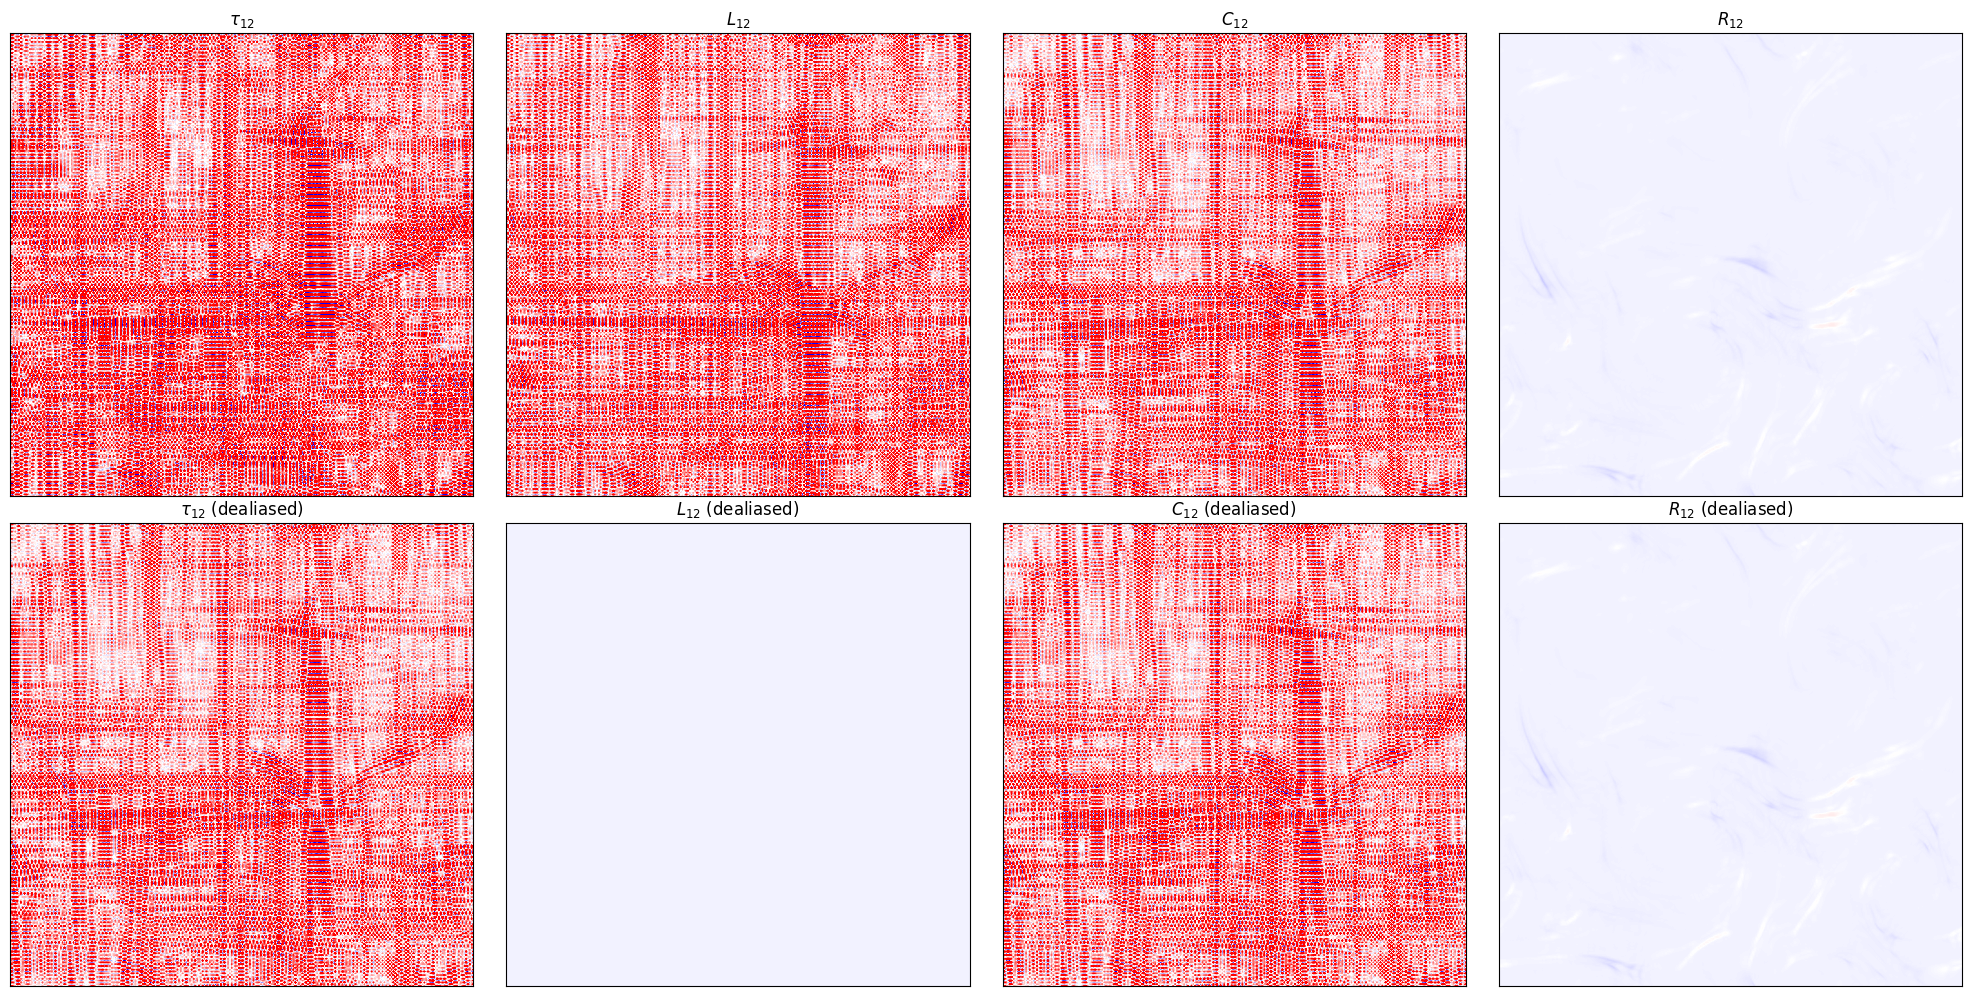

In [5]:
# Plot contour of stresses

# Plot contours of all computed SGS terms
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Determine common limits for color scaling
vmin = 0.1*min(Tau12.min(), Tau12Leonard.min(), Tau12Cross.min(), Tau12Reynolds.min(), 
        Tau12_dealiased.min(), Tau12Leonard_dealiased.min(), Tau12Cross_dealiased.min(), Tau12Reynolds_dealiased.min())
vmax = 0.1*max(Tau12.max(), Tau12Leonard.max(), Tau12Cross.max(), Tau12Reynolds.max(), 
        Tau12_dealiased.max(), Tau12Leonard_dealiased.max(), Tau12Cross_dealiased.max(), Tau12Reynolds_dealiased.max())

# Titles for each subplot
titles = ['$\\tau_{12}$', '$L_{12}$', '$C_{12}$', '$R_{12}$', '$\\tau_{12}$ (dealiased)', '$L_{12}$ (dealiased)', '$C_{12}$ (dealiased)', '$R_{12}$ (dealiased)']

# First row - non-dealiased terms
axs[0, 0].contourf(Tau12, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[0, 1].contourf(Tau12Leonard, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[0, 2].contourf(Tau12Cross, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[0, 3].contourf(Tau12Reynolds, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)

# Second row - dealiased terms
axs[1, 0].contourf(Tau12_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[1, 1].contourf(Tau12Leonard_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[1, 2].contourf(Tau12Cross_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[1, 3].contourf(Tau12Reynolds_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)

# Set titles and make layout adjustments
for ax, title in zip(axs.flat, titles ):
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [6]:
# Testing the conjugate symmetrize padding function: comparing the results of jax and numpy
from py2d.dealias import conjugate_symmetrize_padding, conjugate_symmetrize_padding_jit ,padding_for_dealias, padding_for_dealias_spectral_jit
import jax.numpy as jnp
from jax import jit
import numpy as np

Ngrid = 4
a_np = np.random.rand(Ngrid, Ngrid) + 1j*np.random.rand(Ngrid, Ngrid)
print('original variable = \n', a_np.round(1))

a_jax = jnp.array(a_np)

# Testing the conjugate symmetrize padding function: comparing the results of jax and numpy

a_pad_sym = conjugate_symmetrize_padding(a_np)
a_pad_sym_jax = conjugate_symmetrize_padding_jit(a_jax)

print('Conjugate symmetrize padding for JAX and numpy at Nyquist+/- 1 outputs same results = ', np.allclose(a_pad_sym, np.asarray(a_pad_sym_jax)))
print('numpy', a_pad_sym.round(1))
print('jax  ', np.asarray(a_pad_sym_jax).round(1))

a_pad = padding_for_dealias(a_np, spectral=True)*(2/3)**2
a_pad_jax = padding_for_dealias_spectral_jit(a_jax)*(2/3)**2


a_pad_jax_np = np.asarray(a_pad_jax)

print('Padding for JAX and numpy outputs same results = ', np.allclose(a_pad, a_pad_jax_np))
print('numpy', a_pad.round(1))
print('jax  ', a_pad_jax_np.round(1))



original variable = 
 [[0. +0.8j 0.9+0.6j 0.9+0.5j 0.3+0.3j]
 [0.8+0.7j 0.5+0.2j 0.9+0.1j 0.4+0.8j]
 [0.7+0.7j 0.4+0.1j 0.9+0.5j 0.4+0.5j]
 [0. +0.1j 0.1+0.6j 0.7+0.3j 0.5+0.2j]]
Conjugate symmetrize padding for JAX and numpy at Nyquist+/- 1 outputs same results =  True
numpy [[0. +0.8j 0. +0.j  0.9+0.5j 0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0.7+0.7j 0. +0.j  0.9+0.5j 0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]
jax   [[0. +0.8j 0. +0.j  0.9+0.5j 0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0.7+0.7j 0. +0.j  0.9+0.5j 0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]
Padding for JAX and numpy outputs same results =  True
numpy [[0. +0.8j 0.9+0.6j 0. +0.j  0. +0.j  0. +0.j  0.3+0.3j]
 [0.8+0.7j 0.5+0.2j 0. +0.j  0. +0.j  0. +0.j  0.4+0.8j]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.1j 0.1+0.6j 0. +0.j  0. +0.j  0. +0.j  0.5+0.2j]]